# Milestone 2

For this milestone, we maily did data gathering and preprocessing. Our project involves a lot of data scraping, data wrangling and computer vision. We show a summary of our work in the following parts.

#### 1. [Data scraping](#1.-Data-scraping)

#### 2. [Map extraction](#2.-Map-extraction)

#### 3. [Text processing](#3.-Text-processing)

#### 4. [Avalanches accidents](#4.-Avalanches-accidents)

#### 5. [Goal for milestone 3](#5.-Goal-for-milestone-3)

#### 6. [Questions](#6.-Questions)

In [2]:
from datetime import date, timedelta
from PIL import ImageFilter, Image, ImageDraw
from pylab import contour
from scipy.spatial import distance
from skimage import measure
import branca
import cv2
import folium
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import visvalingamwyatt as vw

%matplotlib inline

## 1. Data scraping

[SLF archives](https://www.slf.ch/en/avalanche-bulletin-and-snow-situation/archive.html) data scraping: we contacted by email the SLF data managers to see if we could have access to their database in SFTP or any nice protocol. But they said we had to use the HTTP interface. No problem, we scraped hard core for one night. This was done in two steps, first extracting all the hierarchy of directories from HTML pages (see `notebooks/slf-scraping.ipynb`) and then downloading the data from each URL with `src/download.py` script. Filters were applied to download only interesting files.

## 2. Map extraction


You can find our work in `notebooks/map-extraction`. We had to develop a handful of methods to extracts the snow/danger regions from the color maps. We applied these methods to danger maps and all kind of snow maps.

- *grey removal:* looking at standard deviation of color channels for each pixel, we could threshold the greys and remove them from the original image,
- *color projection*: due to the noise in the image or minor differences in the color tones, we had to project each pixel's color to the closest color in the reference key (with euclidean distance).
- *mask clipping*: each image having different size or how the country is centered, we had to create binary masks to remove the legend, the title and sometimes extra logos or noise.
- *smoothing*: to remove small imperfections or noisy color projections, we used a median filter in order to get smoother regions and ease the task of contour detection.
- *region detection*: using color detection we extracted the contour of each region.
- *pixel to geo location projection*: once we had contours of the regions in the image (by pixels) we had to transform those into geolocated regions. To do so, we learned a mapping from pixel to geolocations. We took 6 points of references on the image and on Google maps. Note that 3 would have been enough to constraint the problem, but with least square solver we could average out our small mistakes at picking pixel location of the landmarks.
- *GeoJSON creation and website:* to visualize the regions, we transformed them into GeoJSON, smoothed these polygons and displayed them in a really basic HTML interface to check the consistency.

First, we define the colors and the arrays of colors we will need.

In [2]:
black = np.array([0, 0, 0])
white = np.array([255, 255, 255])

green = np.array([204, 255, 102])
yellow = np.array([255, 255, 0])
orange = np.array([255, 153, 0])
red = np.array([255, 0, 0])

danger_colors_code = ['#ccff66', '#ffff00', '#ff9900', '#ff0000']

shades_danger = [green, yellow, orange, red]

danger_image_shades = [green, yellow, orange, red, white]

light_blue = np.array([213, 252, 252])
light_medium_blue = np.array([168, 217, 241])
medium_blue = np.array([121, 161, 229])
dark_medium_blue = np.array([68, 89, 215])
dark_blue = np.array([47, 36, 162])
purple = np.array([91, 32, 196])

snow_color_code = ['#d5fcfc', '#a8d9f1', '#79a1e5', '#4459d7', '#2f24a2', '#5b20c4']

shades_snow = [light_blue, light_medium_blue, medium_blue, dark_medium_blue, dark_blue, purple]

shades_grey = [np.array([c,c,c]) for c in range(255)]

snow_image_shades = [light_blue, light_medium_blue, medium_blue, dark_medium_blue, dark_blue, purple, white]

raw_red = np.array([255, 0, 0])
raw_green = np.array([0, 255, 0])
raw_blue = np.array([0, 0, 255])
raw_pink = np.array([255, 0, 255])
raw_pink = np.array([255, 0, 255])
raw_cyan = np.array([0, 255, 255])
raw_yellow = np.array([255, 255, 0])

The defined functions below will be using those set of colors.

In [14]:
def keep_colors(img, colors, replace_with=white):
    """return a new image with only the `colors` selected, other pixel are `replace_with`"""
    keep = np.zeros(img.shape[:2], dtype=bool)
    for c in colors:
        keep = keep | (c == img).all(axis=-1)
    new_img = img.copy()
    new_img[~keep] = replace_with
    return new_img

def remove_colors(img, colors, replace_with=white):
    """return a new image without the `colors` selected which will be replaced by `replace_with`"""
    keep = np.zeros(img.shape[:2], dtype=bool)
    for c in colors:
        keep = keep | (c == img).all(axis=-1)
    new_img = img.copy()
    new_img[keep] = replace_with
    return new_img

def replace_color(img, color_map):
    """return a new image replacing the image colors which will be mapped to their corresponding colors in `color_map` (df)"""
    new_img = img.copy()
    for _, (source, target) in color_map.iterrows():
        new_img[(img == source).all(axis=-1)] = target
    return new_img

def build_color_map(img_arr, image_shades):
    """return colormap as dataframe"""
    im_df = pd.DataFrame([img_arr[i,j,:] for i,j in np.ndindex(img_arr.shape[0],img_arr.shape[1])])
    im_df = im_df.drop_duplicates()
    image_colors = im_df.as_matrix()
    
    colors = np.zeros(image_colors.shape)
    dist = distance.cdist(image_colors, image_shades, 'sqeuclidean')

    for j in range(dist.shape[0]):
        distances = dist[j,:]
        colors[j, :] = image_shades[distances.argmin()]
        
    color_map = pd.DataFrame(
        {'source': image_colors.tolist(),
         'target': colors.tolist()
        })
    
    return color_map

Here are the two images we will process.

In [4]:
danger_path = '../data/slf/2001/nbk/de/gif/20001230_nbk_de_c.gif'
snow_path = '../data/slf/2010/hstop/en/gif/20100103_hstop_en_c.gif'

danger_img = Image.open(danger_path)
danger_img = danger_img.convert('RGB')
danger_img_arr = np.array(danger_img)

snow_img = Image.open(snow_path)
snow_img = snow_img.convert('RGB')
snow_img_arr = np.array(snow_img)

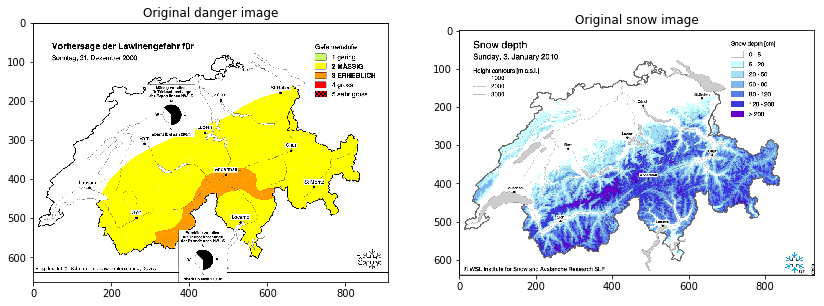

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14,10))

# original danger image
axes[0].imshow(danger_img_arr);
axes[0].set_title('Original danger image');

# original snow image
axes[1].imshow(snow_img_arr);
axes[1].set_title('Original snow image');

In [6]:
def numpify(o):
    if not isinstance(o, np.ndarray):
        o = np.array(o)
    return o


def coord_color(img, color):
    return np.array(list(zip(*(img == color).all(-1).nonzero())))

def open_mask(height, width):
    masks_path = '../map-masks/'
    mask_name = '{}x{}.gif'.format(height, width)
    mask_path = os.path.join(masks_path, mask_name)
    mask = Image.open(mask_path)
    mask = mask.convert('RGB')
    mask = np.array(mask)
    
    landmarks_pix = {
        geo_point: (width, height)
        for geo_point, color in landmarks_colors.items()
        for height, width in coord_color(mask, color)
    }
    
    binary_mask = (mask != 255).any(-1)  # different of white
    return binary_mask, landmarks_pix

# remove contours areas that have more than 30% of white
WHITE_RATIO_THRESHOLD = .3

def color_contours(img, color):
    img = numpify(img)
    color = numpify(color)
    mask = (img == color[:3]).all(axis=-1)
    monocholor = img.copy()
    monocholor[~mask] = 255
    contours = measure.find_contours(mask, 0.5)
    
    # heuristic filter for contours
    filter_contours = []
    for c in contours:
        region = Image.new("L", [img.shape[1], img.shape[0]], 0)
        ImageDraw.Draw(region).polygon(list(map(lambda t: (t[1],t[0]), c)), fill=1)
        region = np.array(region).astype(bool)
        white_ratio = (monocholor == 255).all(axis=-1)[region].mean()
        if white_ratio <= WHITE_RATIO_THRESHOLD:
            filter_contours.append(c)
    return filter_contours
    

We will use the following two binary masks to clip our images in order to extract the useful information only and therefore remove the legends along with the logos and titles.

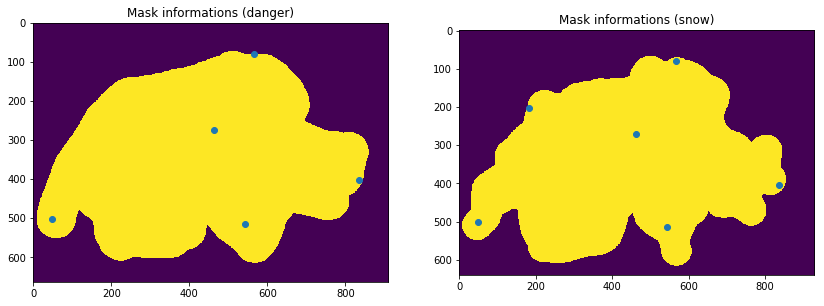

In [7]:
# load mask of this size
leman_west = (6.148131, 46.206042)
quatre_canton_north = (8.435177, 47.082150)
majeur_east = (8.856851, 46.151857)
east_end = (10.472221, 46.544303)
constance_nw = (9.035247, 47.812716)
jura = (6.879290, 47.352935)

landmarks_colors = {
    leman_west: raw_red,
    quatre_canton_north: raw_green,
    majeur_east: raw_blue,
    constance_nw: raw_pink,
    east_end: raw_yellow,
    jura: raw_cyan
}

d_binary_mask, d_landmarks_pix = open_mask(*danger_img_arr.shape[:2])
s_binary_mask, s_landmarks_pix = open_mask(*snow_img_arr.shape[:2])

#display binary masks
fig, axes = plt.subplots(1, 2, figsize=(14,10))

# mask corresponding to danger image
axes[0].imshow(d_binary_mask);
widths, heights = list(zip(*d_landmarks_pix.values()))
axes[0].scatter(widths, heights);
axes[0].set_title('Mask informations (danger)');

# mask corresponding to danger image
axes[1].imshow(s_binary_mask);
widths, heights = list(zip(*s_landmarks_pix.values()))
axes[1].scatter(widths, heights);
axes[1].set_title('Mask informations (snow)');

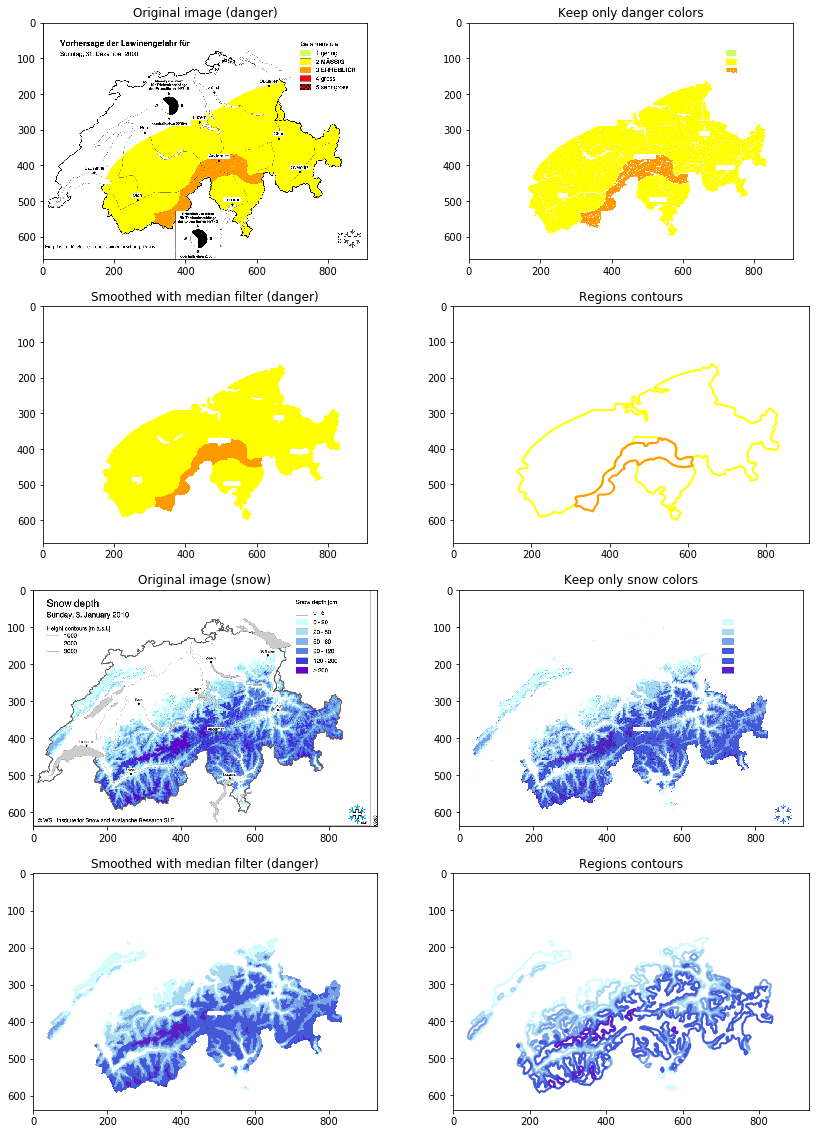

In [8]:
fig, axes = plt.subplots(4, 2, figsize= (14,20))

# -------------------------------------------
#                DANGER IMAGE
# -------------------------------------------

# original image 
axes[0][0].imshow(danger_img_arr);
axes[0][0].set_title('Original image (danger)');

# keep useful colors
d_regions_only = keep_colors(danger_img_arr, shades_danger)
axes[0][1].imshow(d_regions_only);
axes[0][1].set_title('Keep only danger colors');

# clip the binary mask to remove color key
d_regions_only[~d_binary_mask] = 255
d_regions_only = Image.fromarray(d_regions_only).convert('RGB')
d_smoothed = d_regions_only.filter(ImageFilter.MedianFilter(7))
axes[1][0].imshow(d_smoothed);
axes[1][0].set_title('Smoothed with median filter (danger)');

# extract contours
axes[1][1].set_xlim([0, danger_img_arr.shape[1]])
axes[1][1].set_ylim([0, danger_img_arr.shape[0]])
axes[1][1].invert_yaxis()
axes[1][1].set_title('Regions contours')
for color in shades_danger:
    contours = color_contours(d_smoothed, color)
    for contour in contours:
        axes[1][1].plot(contour[:, 1], contour[:, 0], linewidth=2, c=[x / 255 for x in color])
 

# -------------------------------------------
#                SNOW IMAGE
# -------------------------------------------
# original image
axes[2][0].imshow(snow_img_arr);
axes[2][0].set_title('Original image (snow)');

#preprocessing to remove most of the noise
#remove grey colors
nogrey_img_arr = remove_colors(snow_img_arr, shades_grey)
        
#build colormap
color_map = build_color_map(nogrey_img_arr, snow_image_shades)
        
#map image colors to registered shades 
new_img_arr = replace_color(nogrey_img_arr, color_map=color_map)

# keep useful colors
s_regions_only = keep_colors(new_img_arr, shades_snow)
axes[2][1].imshow(s_regions_only);
axes[2][1].set_title('Keep only snow colors');

# clip the binary mask to remove color key
s_regions_only[~s_binary_mask] = 255
s_regions_only = Image.fromarray(s_regions_only).convert('RGB')
s_smoothed = s_regions_only.filter(ImageFilter.MedianFilter(7))
axes[3][0].imshow(s_smoothed);
axes[3][0].set_title('Smoothed with median filter (danger)');

# extract contours
axes[3][1].set_xlim([0, snow_img_arr.shape[1]])
axes[3][1].set_ylim([0, snow_img_arr.shape[0]])
axes[3][1].invert_yaxis()
axes[3][1].set_title('Regions contours')
for color in shades_snow:
    contours = color_contours(s_smoothed, color)
    for contour in contours:
        axes[3][1].plot(contour[:, 1], contour[:, 0], linewidth=2, c=[x / 255 for x in color])

# Contours to map polygon
Once we have contours we want to transform it into geographic coordinates and simplify the polygons.
To do this transformation, we use 5 points on the map to learn a transformation matrix $T$ that maps a pixel of the image to a geolocation. We could use only 3 points to have a valid transformation, but to dicrease the error we use 6 and solve a leastquare problem.

|**Location **|	**Color**|
|---|---|
|Leman W|	red|
|Quatre-cantons N|	green|
|Lac majeur E|	blue|
|Lac Constance NW|	pink|
|Swiss E|	yellow|
|Jura| cyan|

In [13]:
d_pix = np.array(list(map(numpify, d_landmarks_pix.values())))
d_coord = np.array(list(map(numpify, d_landmarks_pix.keys())))

# add 1 bias raw
d_pix_ext = np.vstack([np.ones((1,d_pix.shape[0])), d_pix.T])
d_coord_ext = np.vstack([np.ones((1,d_pix.shape[0])), d_coord.T])

# T = np.linalg.solve(
T = np.linalg.lstsq(d_pix_ext.T, d_coord_ext.T)[0]

s_pix = np.array(list(map(numpify, s_landmarks_pix.values())))
s_coord = np.array(list(map(numpify, s_landmarks_pix.keys())))

# add 1 bias raw
s_pix_ext = np.vstack([np.ones((1,s_pix.shape[0])), s_pix.T])
s_coord_ext = np.vstack([np.ones((1,s_pix.shape[0])), s_coord.T])

# T = np.linalg.solve(
T = np.linalg.lstsq(s_pix_ext.T, s_coord_ext.T)[0]

def transform_pix2map(points):
    """n x 2 array"""
    points_ext = np.hstack([np.ones((points.shape[0], 1)), points])
    points_map = points_ext.dot(T)
    return points_map[:, 1:]

Obtained danger GeoJSON:

In [20]:
SMOOTHING_THRESHOLD = 0.0001

geo_json = {
  "type": "FeatureCollection",
  "features": []
}

for danger_level, color in enumerate(shades_danger):
    for contour in color_contours(d_smoothed, color):
        contour_right = contour.copy()
        contour_right[:,0] = contour[:,1]
        contour_right[:,1] = contour[:,0]
        contour_right = transform_pix2map(contour_right)
        simplifier = vw.Simplifier(contour_right)
        contour_right = simplifier.simplify(threshold=SMOOTHING_THRESHOLD)
        geo_json['features'].append({
            "type": "Feature",
            "properties": {
                "date": "TODO",
                "danger_level": danger_level + 1
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [ list(reversed(contour_right.tolist())) ]
            }
        })

In [21]:
switzerland = (46.875893, 8.289321)
tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}/{x}'
attr = 'Tiles &copy; Esri &mdash; Esri, DeLorme, NAVTEQ, TomTom, Intermap, iPC, USGS, FAO, NPS, NRCAN, GeoBase, Kadaster NL, Ordnance Survey, Esri Japan, METI, Esri China (Hong Kong), and the GIS User Community'
m = folium.Map(location=switzerland, zoom_start=8, tiles=tiles, attr=attr)               

colors = danger_colors_code

def style_function(risk_region):
    level = risk_region['properties']['danger_level']
    color = colors[level - 1]
    return {
        'fillOpacity': .5,
        'weight': 0,
        'fillColor': color,
        'color': 'white',
    }

folium.GeoJson(
    geo_json,
    name='geojson',
    style_function=style_function
).add_to(m)

m

Obtained snow GeoJSON:

In [16]:
SMOOTHING_THRESHOLD = 0.0001

geo_json = {
  "type": "FeatureCollection",
  "features": []
}

for snow_level, color in enumerate(shades_snow):
    for contour in color_contours(s_smoothed, color):
        contour_right = contour.copy()
        contour_right[:,0] = contour[:,1]
        contour_right[:,1] = contour[:,0]
        contour_right = transform_pix2map(contour_right)
        simplifier = vw.Simplifier(contour_right)
        contour_right = simplifier.simplify(threshold=SMOOTHING_THRESHOLD)
        geo_json['features'].append({
            "type": "Feature",
            "properties": {
                "date": "TODO",
                "snow_level": snow_level + 1
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [ list(reversed(contour_right.tolist())) ]
            }
        })

In [18]:
switzerland = (46.875893, 8.289321)
tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}/{x}'
attr = 'Tiles &copy; Esri &mdash; Esri, DeLorme, NAVTEQ, TomTom, Intermap, iPC, USGS, FAO, NPS, NRCAN, GeoBase, Kadaster NL, Ordnance Survey, Esri Japan, METI, Esri China (Hong Kong), and the GIS User Community'
m = folium.Map(location=switzerland, zoom_start=8, tiles=tiles, attr=attr)               

colors = snow_color_code

def style_function(risk_region):
    level = risk_region['properties']['danger_level']
    color = colors[level - 1]
    return {
        'fillOpacity': .5,
        'weight': 0,
        'fillColor': color,
        'color': 'white',
    }

folium.GeoJson(
    geo_json,
    name='geojson',
    style_function=style_function
).add_to(m)

m

## 3. Text processing

We used daily avalanche reports to extract temperature and wind observations per day. You can find this process described in depth in `notebooks/text-extraction.ipynb`.

- *PDF to text*: we first extracted the text from PDF files, in order to be able to process  the text.
- *Avalanche reports investigation*: these reports were analysed to understand the way the reports were done and find the best solution to extract the data we want in a repeatable way. The difficulty was that, depending on the year and month selected, the reports were organized differently.
- *Paragraph selection*: in the algorithm, the first step consisted in selecting the paragraph in which temperature and wind (of the day) is found. This step was necessary to prevent unwanted matching (for example prevision temperatures)
- *Regex filtering*: meaningful patterns were filtered by keywords to get substrings containing the main information. (for example ['plus 6 degre'] or ['moins 8 degre'])
- *Location matching*: temperatures were associated with their respective location, which could correspond to north, south, east or west.
- *DataFrame creation*: Wind and Temperature data were extracted and loaded into DataFrames. In order to assess the quality of our extraction, we selected a sample and checked by hand the results.

## 4. Avalanches accidents


[SLF avalanche accidents](https://www.slf.ch/en/avalanches/destructive-avalanches-and-avalanche-accidents/avalanche-accidents-of-the-past-20-years.html) extraction: we downloaded accidents data from the website with precise coordinates for each accident. We made a map showing accidents depending on the risk level to visualise the data points.

In [3]:
# Load avalanche accidents data
df_accidents = pd.read_csv('../data/accidents/raw_accidents.csv')
df_accidents['Date'] = pd.to_datetime(df_accidents['Date'])

# Data cleaning
changing_danger = (df_accidents['Danger level'].str.contains('↗︎') == True)  # == True needed here
df_accidents.loc[changing_danger, 'Danger level'] = df_accidents.loc[changing_danger, 'Danger level'].str[0]
df_accidents['Danger level'] = df_accidents['Danger level'].replace('-',np.nan)
df_accidents['Danger level'] = pd.to_numeric(df_accidents['Danger level'])
df_accidents['Danger level'] = df_accidents['Danger level'].abs()

,Date,Canton,Starting zone,Elevation,Aspect,Activity,Danger level,caught,buried,killed
0,26.10.97,BE,Kandersteg,3420,N,1,-,2,1.0,2
1,19.12.97,GR,St. Moritz,2560,SW,2,3,2,1.0,1
2,21.12.97,UR,Andermatt,2940,NW,3,4,2,1.0,1
3,29.12.97,VS,Bagnes,2435,NE,1,3,2,2.0,1
4,04.01.98,UR,Andermatt,2400,N,2,3,2,1.0,1


We also map the activities index to some more meaningful categories

| Index | Category |
| --- | --- |
| 1 | Backcountry touring (incl. for instance snow-shoeing, mountaineering)|
| 2 | Off-piste skiing and snowboarding (access generally from a ski area) |
| 3 | Transportation corridors (including for instance ski runs or roads) | 
| 4 | Buildings |

In [6]:
df_accidents['Activity'] = df_accidents['Activity'].replace({
    1: 'Backcountry touring',
    2: 'Off-piste skiing',
    3: 'Transportation',
    4: 'Buildings'
})

In [7]:
df_accidents.head()

,Date,Canton,Starting zone,Elevation,Aspect,Activity,Danger level,caught,buried,killed
0,1997-10-26,BE,Kandersteg,3420,N,Backcountry touring,NaN,2,1.0,2
1,1997-12-19,GR,St. Moritz,2560,SW,Off-piste skiing,3.0,2,1.0,1
2,1997-12-21,UR,Andermatt,2940,NW,Transportation,4.0,2,1.0,1
3,1997-12-29,VS,Bagnes,2435,NE,Backcountry touring,3.0,2,2.0,1
4,1998-04-01,UR,Andermatt,2400,N,Off-piste skiing,3.0,2,1.0,1


We create the Swiss map with the datapoints visualized.

In [8]:
# Create map centered on Switzerland
switzerland = (46.875893, 8.289321)
m = folium.Map(location=switzerland, zoom_start=8, tiles='https://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}', attr='Tiles &copy; Esri &mdash; Esri, DeLorme, NAVTEQ')

In order to locate each avalanche accident on the swiss map, we decided to use geopy in order to find the latitude and longitude correponding to each city name in the dataframe.

In [9]:
# Find coordinates for each avanlanche accident in Switzerland
coordinates = pd.read_excel('../accident_data/coordinates.xlsx')

# Coordinates are added to the dataframe for each accident
df_accidents = df_accidents.assign(Longitude = coordinates.Longitude, Latitude = coordinates.Latitude)
df_accidents.head()

,Date,Canton,Starting zone,Elevation,Aspect,Activity,Danger level,caught,buried,killed,Latitude,Longitude
0,1997-10-26,BE,Kandersteg,3420,N,Backcountry touring,NaN,2,1.0,2,46.469813,7.728972
1,1997-12-19,GR,St. Moritz,2560,SW,Off-piste skiing,3.0,2,1.0,1,46.502976,9.772840
2,1997-12-21,UR,Andermatt,2940,NW,Transportation,4.0,2,1.0,1,46.602754,8.612660
3,1997-12-29,VS,Bagnes,2435,NE,Backcountry touring,3.0,2,2.0,1,46.034050,7.199696
4,1998-04-01,UR,Andermatt,2400,N,Off-piste skiing,3.0,2,1.0,1,46.617105,8.616889


For each accident, a marker is added on the map at the right location, with popups giving information about the starting zone, the elevation, the danger level, the number of people caught and killed.

In [10]:
import branca.colormap as cm

colors = ['#CCFF66','#FFFF00','#FF9B00', '#FF0000', '#800080']

colorscale = cm.StepColormap(
    colors,
    vmin=0., vmax=5.,
    index=range(6),
    caption="Avalanche Danger Level"
)

for i, values in df_accidents.iterrows():
    information = [
        ("Date", values["Date"].strftime("%Y-%m-%d")),
        ("Starting zone", values["Starting zone"]),
        ("Elevation", values["Elevation"]),
        ("Danger level", int(values["Danger level"]) if not np.isnan(values["Danger level"]) else "None"),
        ("Caught", values["caught"]),
        ("Killed", values["killed"]),
    ]
    
    pop_up = folium.Popup("<dl>" + ''.join(["<dt>{}: </dt><dd>{}</dd>".format(k, v) for k, v in information]) + "</dl>")
    color_circle = colorscale(values['Danger level']) if values['Danger level'] >= 1 else '#808080'
    location = [values.Latitude, values.Longitude]
    folium.CircleMarker(location, popup=pop_up, color=color_circle, radius=5).add_to(m)

In [11]:
m.add_child(colorscale)
m

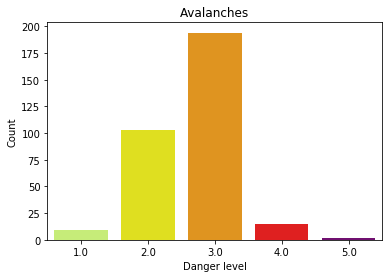

In [12]:
fig, ax = plt.subplots(1, sharey=True);

sns.countplot(x="Danger level", data=df_accidents, ax=ax, palette=colors);
ax.set_title('Avalanches');
ax.set_xlabel('Danger level');
ax.set_ylabel('Count');